Importing the libraries and the csv

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import WhitespaceTokenizer

import re

from nrclex import NRCLex

from wordcloud import WordCloud

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()

Color palette for genres. We use the function of matplotlib.colors to convert the palette in a format for matplotlib

In [ ]:
from matplotlib.colors import ListedColormap

c = ['#8a3ffc', '#33b1ff', '#007d79', '#ff7eb6', '#fa4d56', '#6fdc8c', '#d12771', '#d2a106', '#ba4e00', '#d4bbff']
col = ListedColormap(sns.color_palette(c).as_hex())

English stopwords and custom set of stopwords

In [ ]:
STOPWORDS = nltk.corpus.stopwords.words("english") 
lemmatizer = nltk.stem.WordNetLemmatizer()

STOPWORDS.extend(["i'm","eh", "oh", "aren’t","are not","can’t","cannot","couldn’t","could not","didn’t","did not","doesn’t","does not","don’t","do not","hadn’t","had not","hasn’t","has not","haven’t","have not","he’d","he had","he would","he’ll","he will","he shall","he’s","he is","he has","I’d","I had","I would","I’ll","I will","I shall","I’m","I am","I’ve","I have","isn’t","is not","let’s","let us","mightn’t","might not","mustn’t","must not","shan’t","shall not","she’d","she had","she would","she’ll","she will","she shall","she’s","she is","she has","shouldn’t","should not","that’s","that is","that has","there’s","there is","there has","they’d","they had","they would","they’ll","they will","they shall","they’re","they are","they’ve","they have","we’d","we had","we would","we’re","we are","we’ve","we have","weren’t","were not","what’ll","what will","what shall","what’re","what are","what’s","what is","what has","what’ve","what have","where’s","where is","where has","who’d","who had","who would","who’ll","who will","who shall","who’re","who are","who’s","who is","who has","who’ve","who have","won’t","will not","wouldn’t","would not","you’d","you had","you would","you’ll","you will","you shall","you’re","you are","you’ve","you have", "know"])

### Load the dataset

We load the csv e we drop the language column (all songs are already in English).

Drop also the records (6 in total) with year previous to 1968, inconsistent values.

In [ ]:
df = pd.read_csv('./data/lyrics_def_noDupl.csv')
df.drop('language', axis=1, inplace=True)
df.drop(df[df.year < 1968].index, inplace=True)
df.reset_index(drop=True, inplace=True)

## Emotion Analysis

### Functions

It removes some abbreviations from the text

In [ ]:
def clean_abbreviation(token):
    if token == 'u':
        return 'you'
    if token == '\'d':
        return ''
    if token == 'id':
        return 'i'
    if token == 'im':
        return 'i am'
    if token == 'i\'ma':
        return 'i am a'
    if token == 'ima':
        return 'i am a'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == 'yall':
        return 'you all'
    if token == 'ive':
        return 'i have'
    if token == 'dont':
        return 'do not'
    if token == '4got' or token == '4gotten':
        return 'forget'
    return token

Cleaning the text.

It then creates a new column in the dataframe

In [ ]:
def clearLyrics(df):
    lyrics_cleaned = []

    for idx, row in tqdm(df.iterrows(), desc='Cleaning Lyrics', total=len(df)):
        #if idx % 50000 == 0:
        #    print(f'Song number {idx} cleaned')
            
        new_lyric = ""
        new_lyric = re.sub("[^\x00-\x7F]+", ' ', row.lyrics) ## elimina caratteri strani a causa della codifica in ASCII
        new_lyric = re.sub("[\(\[].*?[\)\]]", ' ', new_lyric) ## elimina le parole contenute dentro le parentesi
        new_lyric = re.sub("x[0-9]+", " ", new_lyric) ## elimina x2, x3, ecc.
        new_lyric = re.sub("[0-9]x+", " ", new_lyric) ## elimina 2x, 3x, ecc.
        new_lyric = re.sub("[^\w\s^']", '', new_lyric) ##elimina punteggiatura tranne che apostrofi
        new_lyric = re.sub("\\n", " ", new_lyric) ## elimina gli /n
        new_lyric = re.sub(' {2,}', " ", new_lyric) ## elimina gli spazi superflui
        new_lyric = new_lyric.lower().split()
        new_lyric = ' '.join((clean_abbreviation(tok.lower()) for tok in new_lyric))
        new_lyric = ' '.join([lemmatizer.lemmatize(i) for i in new_lyric.split() if i not in STOPWORDS])

        lyrics_cleaned.append(new_lyric)

    df['lyrics_cleaned'] = lyrics_cleaned

    return df

All the emotions for each lyrics are generated. Each word is associated to a sentiment (positive or negative) and to zero or more emotions. For our analysis we decided to focus only on the emotions so we remove the sentiments and we balance all the other values to keep their distribution with sum equal to 1.

The attribute emotions is then added to the dataframe.

In [ ]:
def generateEmotions(df):
    list_emotions = []

    for idx, row in df.iterrows():
        if idx % 50000 == 0:
            print(f'Emotions for song number {idx} extracted')

        curr_emotions = NRCLex(row.lyrics_cleaned)

        posneg_sum = curr_emotions.affect_frequencies['positive'] + curr_emotions.affect_frequencies['negative']
        if posneg_sum == 1:
            posneg_sum = 0.00000000000001

        curr_emotions.affect_frequencies.pop('positive')
        curr_emotions.affect_frequencies.pop('negative')

        curr_emotions.affect_frequencies.update((x, y/(1-posneg_sum)) for x, y in curr_emotions.affect_frequencies.items())

        list_emotions.append(curr_emotions)

    df['emotions'] = list_emotions

    return df

From the list of object with the emotions, we generate a dictionary with the emotions as keys and the frequiences of each emotion as values.

A list of dictionaries is then created.

In [ ]:
def emotionDictSongs(df):
    
    emotions_list = []
    
    for idx, row in df.iterrows():
        emotions_dict = {}
        for e, v in row['emotions'].affect_frequencies.items():
            if e in emotions_dict:
                emotions_dict[e] += v
            else:
                emotions_dict[e] = v

        emotions_list.append(emotions_dict)
    
    return emotions_list

Using the list of dictionaries generated before, we create a new dataframe with an attribute for each emotion.

We remove the column 'anticip' because its value are all equal to zero (probably a bug of the library) and then we merge the main dataframe and the the one with the emotions.

In [ ]:
def addEmotionsAttributes(df):
    list_all_emotions = emotionDictSongs(df)

    df_emotions_list = pd.DataFrame(list_all_emotions)
    df_emotions_list.drop(columns='anticip', inplace=True)

    df_emotions_list.fillna(0, inplace=True)

    return pd.concat([df, df_emotions_list], axis=1)

With this function we extract a dataframe with only the numeric values of the emotions and another dataframe with only the genres.

In [ ]:
def generateDataframeValues(df):
    df_X = df.copy(deep=True)
    df_y = df['genre'].copy(deep=True)
    df_X.drop(columns=['artist', 'song', 'year', 'lyrics', 'lyrics_cleaned', 'emotions', 'genre'], inplace=True)

    return df_X, df_y

From the dataframe we extract the outliers (last percentile) for each emotion.

It returns the list of outlier indexes.

In [ ]:
def outlierExtraction(df, emotion, quantile):
    q = df[emotion].quantile(quantile)
    list_idx = list()
    for idx, row in df.iterrows():
        if df.loc[idx, emotion] > q:
            list_idx.append(idx)
    
    return list_idx

Plot of outliers for each emotion, divided by genre.

In [ ]:
def outlierAllPlots(df, df_X, list_emotions, quantile):
    for e in list_emotions:
        print(f'Outilers of emotion {e}')
        print(f'- {quantile} percentile value: {df[e].quantile(quantile)}')
        sns.stripplot(data=df.iloc[outlierExtraction(df_X, e, quantile)], x=e, y='genre', order=list(df.genre.unique()), jitter=True, palette=c)
        plt.ylabel('Genres')
        plt.xlabel(f'{e} Value')
        plt.show()

In [ ]:
def outlierPlot(df, list_outilers, emotion):
    print(f'-- Outliers of emotion {emotion}')
    print(f'- 99th percentile value: {df[emotion].quantile(0.99)}')
    sns.stripplot(data=df.iloc[list_outilers], x=emotion, y='genre', order=list(df.genre.unique()), jitter=True, palette=c)
    plt.ylabel('Genres')
    plt.xlabel(f'{emotion} Value')
    plt.show()

Word cloud for a specific text

In [ ]:
def plot_wordcloud(text):

    words = ' '.join(text)

    wordcloud = WordCloud(width = 1200, height = 700, background_color ='white',collocations=False,
          min_font_size = 10).generate(words)

    # plot the WordCloud image
    plt.figure(figsize = (12, 7), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

It generates the vocabulary from the lyrics of the outliers of a genre.

In [ ]:
def generateEmotionVoc(df, outlier_idx):
    emotion_voc = []

    for idx, row in df.iloc[outlier_idx].iterrows():
        for e in row.lyrics_cleaned.split():
            emotion_voc.append(e)
    
    return emotion_voc

Given the dataset and the list of genres, this function creates a dictionary with the count of each genre.

In [ ]:
def genreCount(df, genres_list):
    dict_count = dict()
    for genre in genres_list:
        dict_count[genre] = 0

    for idx, row in df.iterrows():
        dict_count[row.genre] += 1
    
    return dict_count

Dictionary with the ratio of outliers for each genre on the total of songs of that genre.

In [ ]:
def ratioOutlier(outlierCount, genreCount):
    dict_outlier = {}

    for genre in genreCount:
        dict_outlier[genre] = outlierCount[genre] / genreCount[genre] * 100
    
    return dict_outlier

This function executes a complete analysis on the outliers for each emotion.

In [ ]:
def outlierAnalysis(df):
    emotions_list = ['fear', 'anger', 'trust', 'surprise', 'sadness', 'disgust', 'joy', 'anticipation']

    for em in emotions_list:
        print(f'--- Analysis of emotion {em} ---')
        list_outliers = outlierExtraction(df, em, 0.99)
        #df_X_test, df_y_test = generateDataframeValues(df)
        outlierPlot(df, list_outliers, em)
        print(f'-- Number of outliers:')
        print(genreCount(df.iloc[list_outliers], list(df.genre.unique())))
        print(ratioOutlier(genreCount(df.iloc[list_outliers], list(df.genre.unique())), genreCount(df, list(df.genre.unique()))))
        print(f'-- Artist list')
        print(df.iloc[list_outliers].artist.value_counts())
        print(f'-- Wordcloud for {em}')
        plot_wordcloud(generateEmotionVoc(df, list_outliers))
        print(f'---------------------------------')
    

In [ ]:
def emotionsPerGenre(df, genres_list):
    aggregate_emotions = []

    emotions_list = ['fear', 'anger', 'trust', 'surprise', 'sadness', 'disgust', 'joy', 'anticipation']

    for genre in genres_list:
        dict_emotions = {'genre': genre}
        for em in emotions_list:
            dict_emotions.update({em: df.loc[df['genre'] == genre, em].mean()})
        aggregate_emotions.append(dict_emotions)
    
    return pd.DataFrame.from_dict(aggregate_emotions)

### Compute the emotions for all the songs

In [ ]:
df = clearLyrics(df)
df = generateEmotions(df)
df = addEmotionsAttributes(df)

Cleaning Lyrics:   0%|          | 0/189388 [00:00<?, ?it/s]

Emotions for song number 0 extracted
Emotions for song number 50000 extracted
Emotions for song number 100000 extracted
Emotions for song number 150000 extracted


--- Analysis of emotion fear ---
-- Outliers of emotion fear
- 99th percentile value: 0.40425531914893614


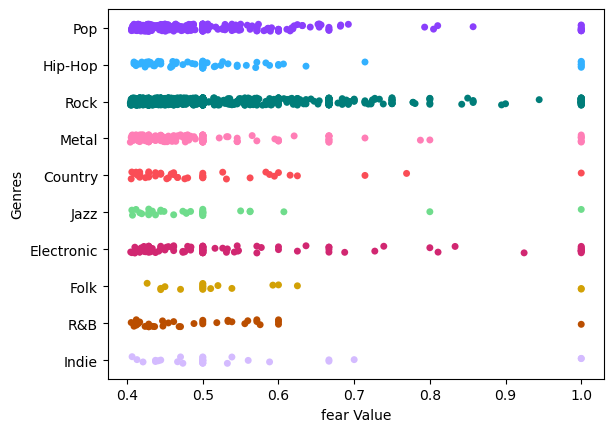

-- Number of outliers:
{'Pop': 285, 'Hip-Hop': 75, 'Rock': 1062, 'Metal': 196, 'Country': 45, 'Jazz': 34, 'Electronic': 109, 'Folk': 20, 'R&B': 36, 'Indie': 29}
{'Pop': 0.9909941235787059, 'Hip-Hop': 0.37191312109491226, 'Rock': 1.1800262228049512, 'Metal': 0.9487849743440798, 'Country': 0.3843525794328664, 'Jazz': 0.7034967928822677, 'Electronic': 1.767472028538998, 'Folk': 1.2586532410320956, 'R&B': 1.3172338090010975, 'Indie': 1.0442924018725244}
-- Artist list
david-bowie            10
anti-flag               8
godflesh                8
beck                    8
ac-dc                   7
                       ..
chicago-the-musical     1
the-grates              1
gojira                  1
the-death-set           1
army-of-me              1
Name: artist, Length: 1282, dtype: int64
-- Wordcloud for fear


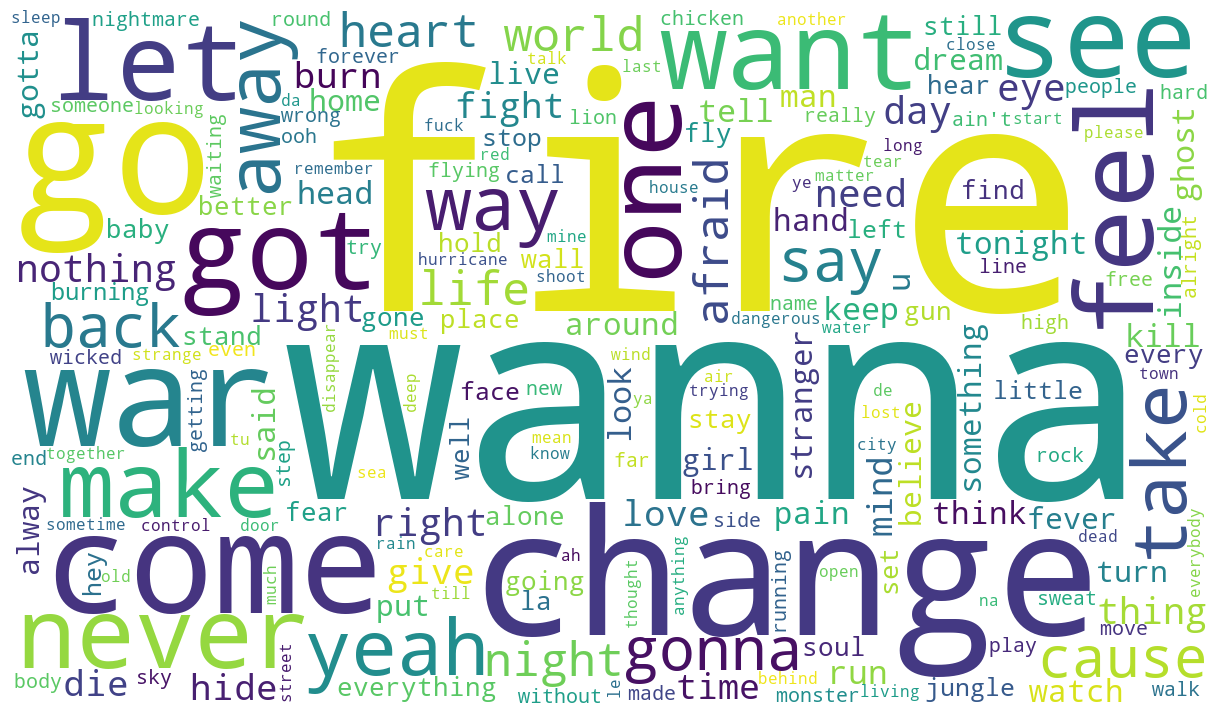

---------------------------------
--- Analysis of emotion anger ---
-- Outliers of emotion anger
- 99th percentile value: 0.33333333333333326


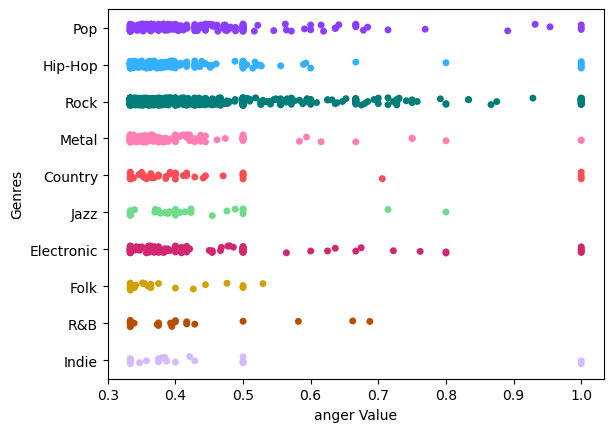

-- Number of outliers:
{'Pop': 217, 'Hip-Hop': 197, 'Rock': 1030, 'Metal': 170, 'Country': 46, 'Jazz': 34, 'Electronic': 117, 'Folk': 28, 'R&B': 25, 'Indie': 22}
{'Pop': 0.75454640286519, 'Hip-Hop': 0.9768917980759694, 'Rock': 1.1444698771083803, 'Metal': 0.8229257430535385, 'Country': 0.3928937478647079, 'Jazz': 0.7034967928822677, 'Electronic': 1.8971947462299334, 'Folk': 1.762114537444934, 'R&B': 0.9147457006952067, 'Indie': 0.7922218221101909}
-- Artist list
ac-dc                  14
fall                   12
chumbawamba            12
casualties              9
david-bowie             9
                       ..
chicago-the-musical     1
bonnie-owens            1
chuck-berry             1
dan-seals               1
damon-albarn            1
Name: artist, Length: 1229, dtype: int64
-- Wordcloud for anger


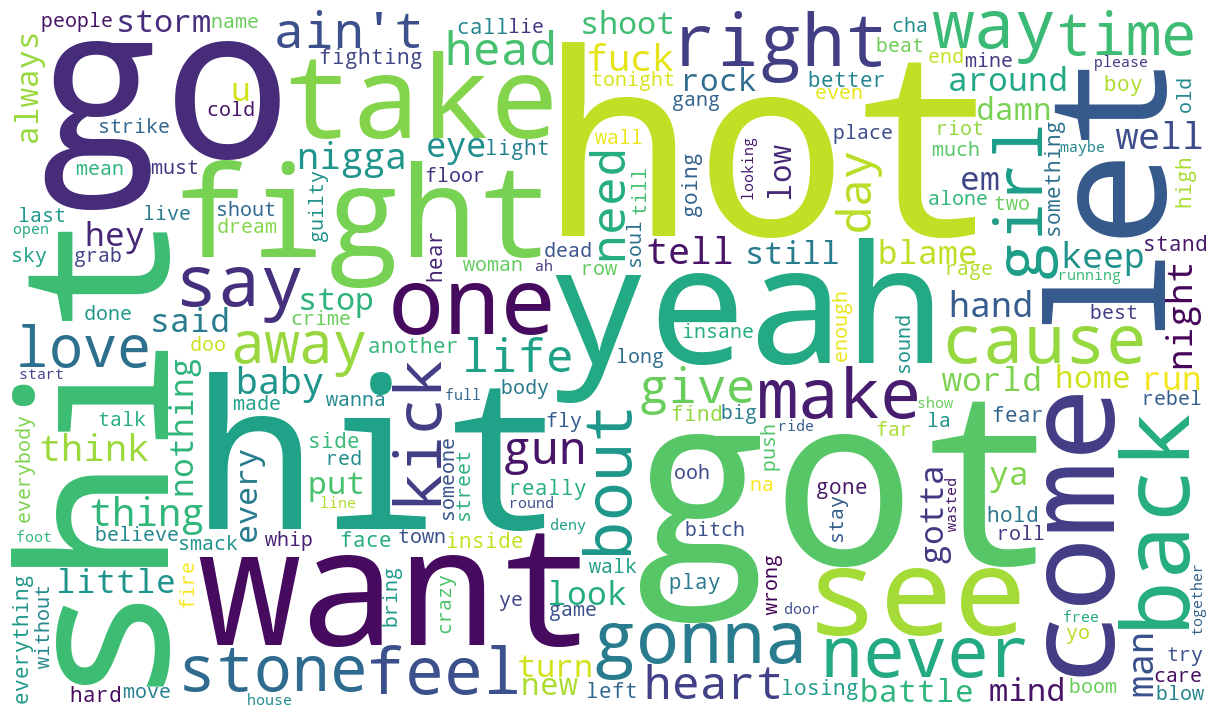

---------------------------------
--- Analysis of emotion trust ---
-- Outliers of emotion trust
- 99th percentile value: 0.4666666666666667


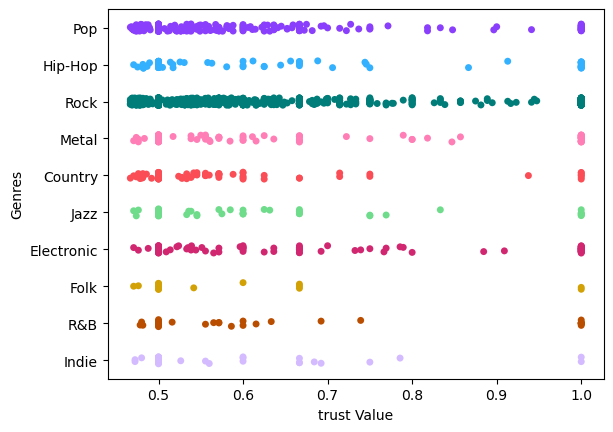

-- Number of outliers:
{'Pop': 274, 'Hip-Hop': 94, 'Rock': 1049, 'Metal': 119, 'Country': 88, 'Jazz': 58, 'Electronic': 120, 'Folk': 16, 'R&B': 33, 'Indie': 40}
{'Pop': 0.9527452275809312, 'Hip-Hop': 0.46613111177228994, 'Rock': 1.165581457365719, 'Metal': 0.576048020137477, 'Country': 0.7516228220020499, 'Jazz': 1.2000827643285745, 'Electronic': 1.9458407653640344, 'Folk': 1.0069225928256766, 'R&B': 1.2074643249176729, 'Indie': 1.4404033129276197}
-- Artist list
frank-zappa                 28
chumbawamba                 15
beach-boys                  12
agoraphobic-nosebleed       12
electric-light-orchestra    10
                            ..
alabama                      1
eyes-of-fire                 1
beseech                      1
flying-burrito-brothers      1
clay-walker                  1
Name: artist, Length: 1190, dtype: int64
-- Wordcloud for trust


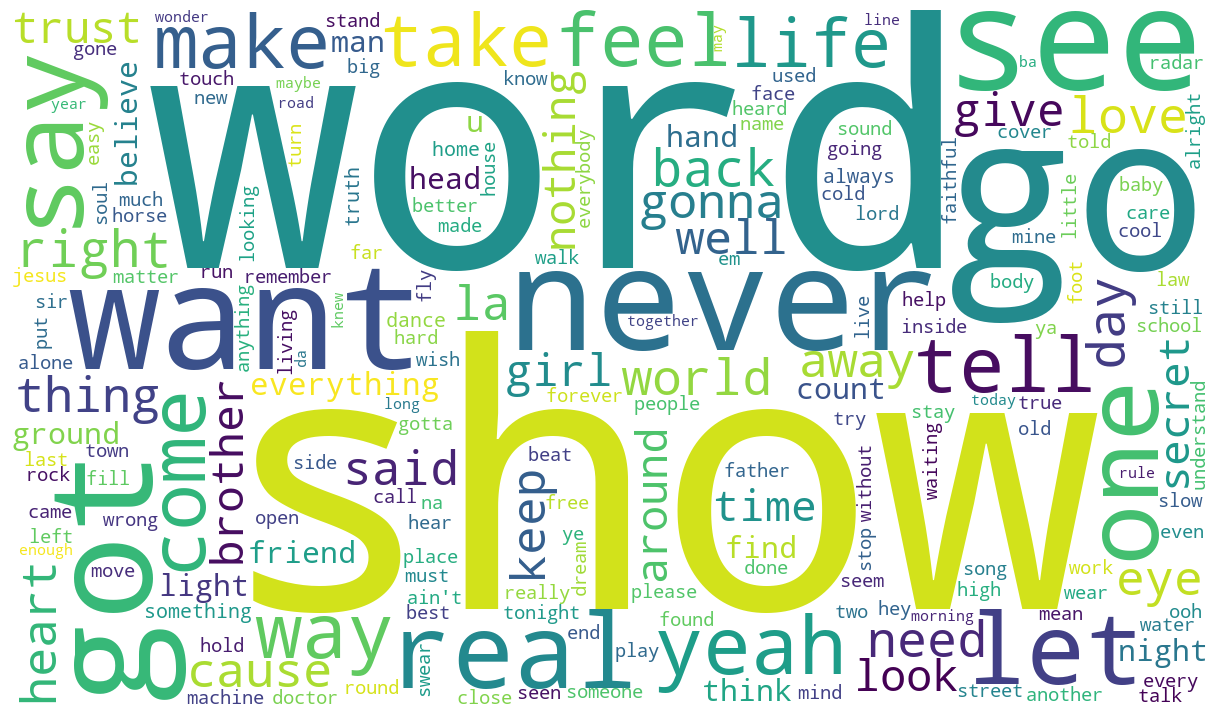

---------------------------------
--- Analysis of emotion surprise ---
-- Outliers of emotion surprise
- 99th percentile value: 0.28571428571428575


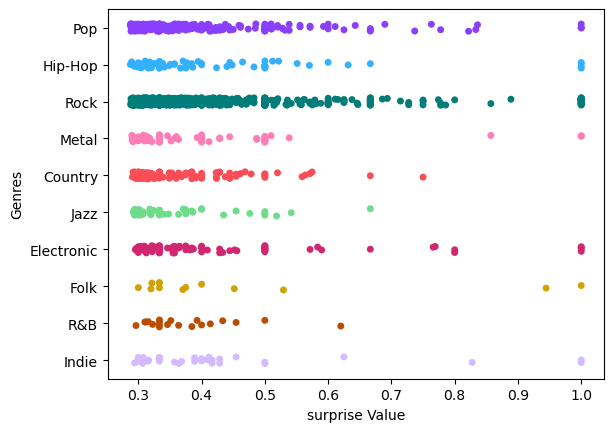

-- Number of outliers:
{'Pop': 327, 'Hip-Hop': 89, 'Rock': 1034, 'Metal': 82, 'Country': 109, 'Jazz': 52, 'Electronic': 112, 'Folk': 13, 'R&B': 20, 'Indie': 40}
{'Pop': 1.1370353628429362, 'Hip-Hop': 0.44133690369929585, 'Rock': 1.1489144203204515, 'Metal': 0.39694065253170685, 'Country': 0.9309873590707208, 'Jazz': 1.0759362714669978, 'Electronic': 1.8161180476730987, 'Folk': 0.8181246066708621, 'R&B': 0.7317965605561654, 'Indie': 1.4404033129276197}
-- Artist list
barbra-streisand            9
chumbawamba                 8
frank-sinatra               7
eric-clapton                7
dolly-parton                7
                           ..
giles                       1
black-moth-super-rainbow    1
boomtown-rats               1
blessid-union-of-souls      1
corroded                    1
Name: artist, Length: 1274, dtype: int64
-- Wordcloud for surprise


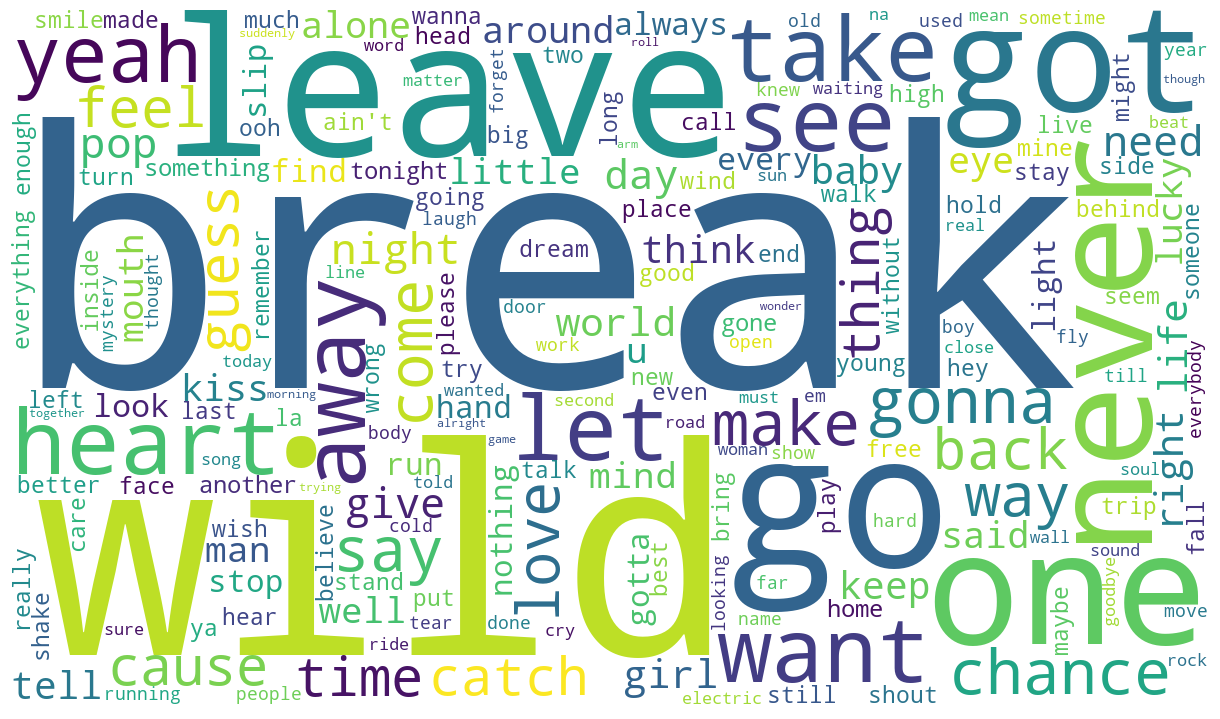

---------------------------------
--- Analysis of emotion sadness ---
-- Outliers of emotion sadness
- 99th percentile value: 0.46302168021680434


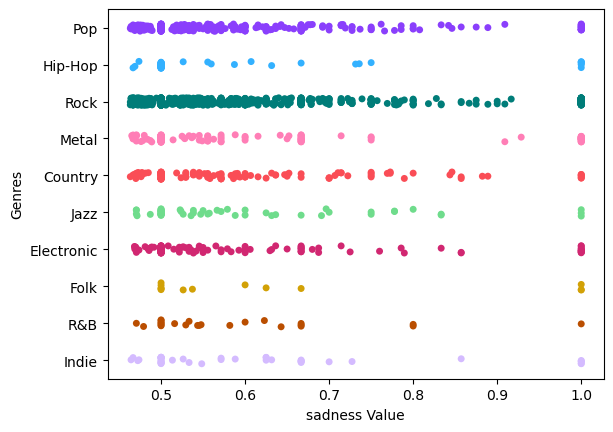

-- Number of outliers:
{'Pop': 282, 'Hip-Hop': 46, 'Rock': 1019, 'Metal': 154, 'Country': 128, 'Jazz': 55, 'Electronic': 131, 'Folk': 13, 'R&B': 25, 'Indie': 41}
{'Pop': 0.9805626064884037, 'Hip-Hop': 0.22810671427154616, 'Rock': 1.132247383275184, 'Metal': 0.7454739084132056, 'Country': 1.093269559275709, 'Jazz': 1.138009517897786, 'Electronic': 2.124209502189071, 'Folk': 0.8181246066708621, 'R&B': 0.9147457006952067, 'Indie': 1.4764133957508103}
-- Artist list
beck                        12
bill-monroe                 10
chumbawamba                 10
gary-moore                   8
electric-light-orchestra     8
                            ..
divine                       1
brazil                       1
cantatonia                   1
connie-lim                   1
corroded                     1
Name: artist, Length: 1238, dtype: int64
-- Wordcloud for sadness


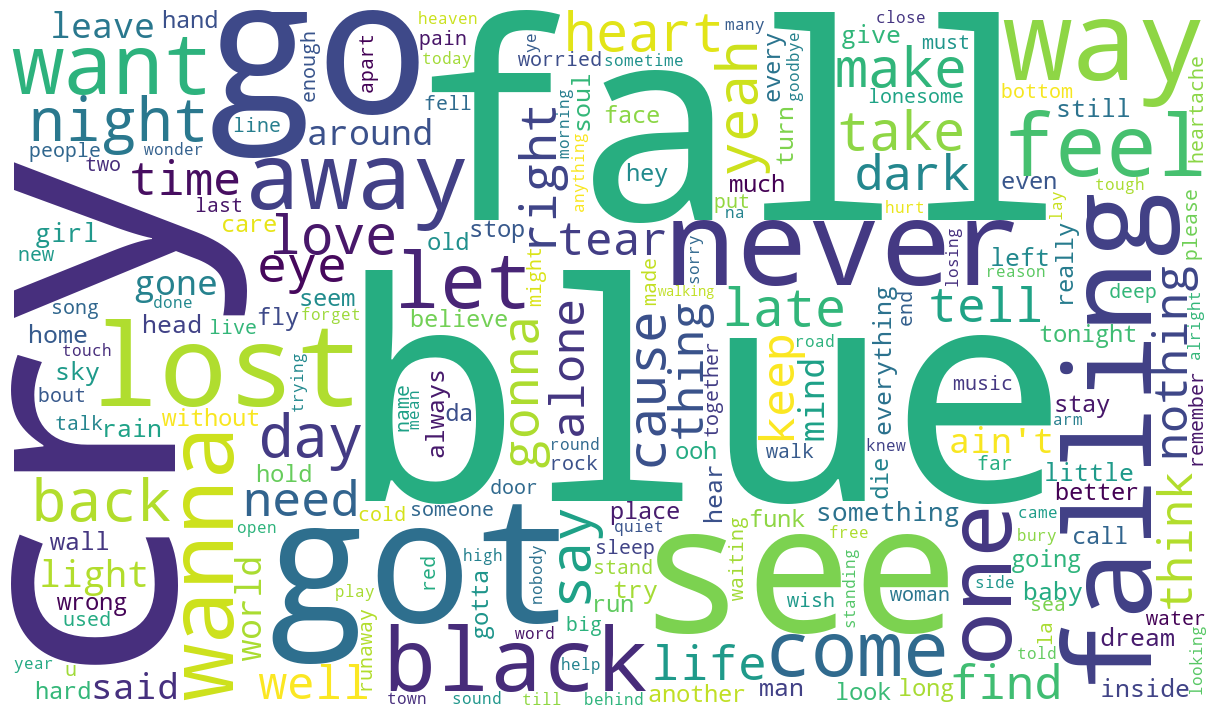

---------------------------------
--- Analysis of emotion disgust ---
-- Outliers of emotion disgust
- 99th percentile value: 0.31428571428571433


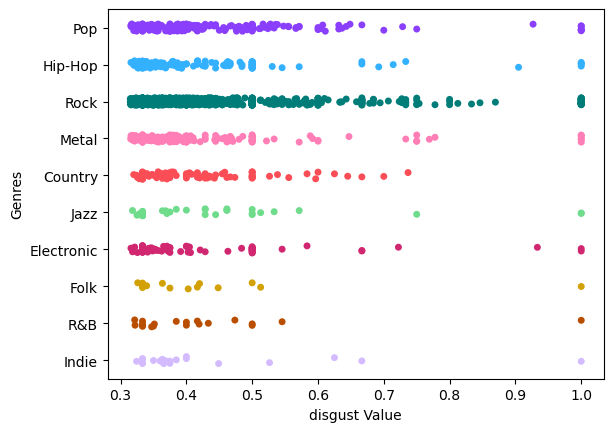

-- Number of outliers:
{'Pop': 238, 'Hip-Hop': 156, 'Rock': 1033, 'Metal': 205, 'Country': 91, 'Jazz': 35, 'Electronic': 77, 'Folk': 18, 'R&B': 20, 'Indie': 20}
{'Pop': 0.8275670224973051, 'Hip-Hop': 0.7735792918774174, 'Rock': 1.1478032845174337, 'Metal': 0.9923516313292672, 'Country': 0.7772463272975743, 'Jazz': 0.7241878750258638, 'Electronic': 1.2485811577752552, 'Folk': 1.1327879169288861, 'R&B': 0.7317965605561654, 'Indie': 0.7202016564638098}
-- Artist list
frank-zappa                                            21
carcass                                                16
fall                                                   14
elton-john                                             14
agoraphobic-nosebleed                                  14
                                                       ..
colonel-les-claypool-s-fearless-flying-frog-brigade     1
devon                                                   1
frenzal-rhomb                                           1
day-of-fi

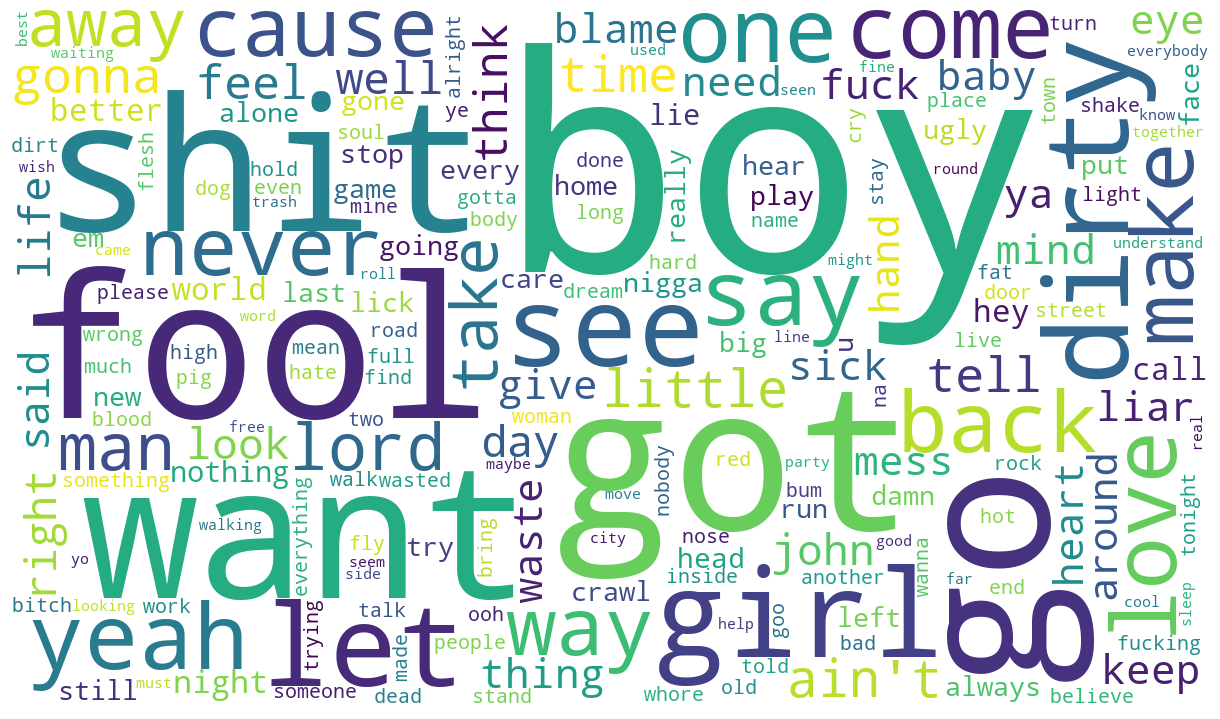

---------------------------------
--- Analysis of emotion joy ---
-- Outliers of emotion joy
- 99th percentile value: 0.6


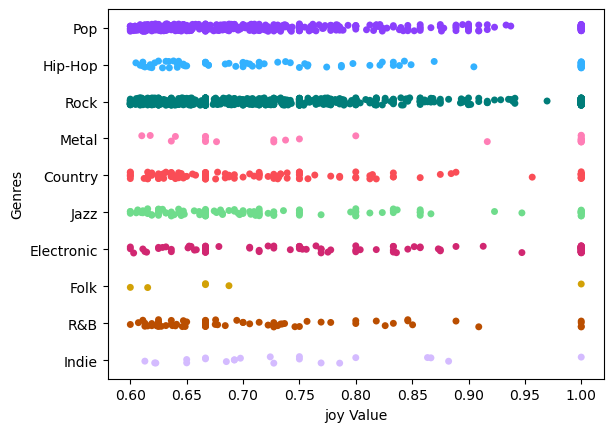

-- Number of outliers:
{'Pop': 478, 'Hip-Hop': 83, 'Rock': 832, 'Metal': 26, 'Country': 135, 'Jazz': 112, 'Electronic': 113, 'Folk': 6, 'R&B': 75, 'Indie': 22}
{'Pop': 1.6620883897214784, 'Hip-Hop': 0.41158385401170283, 'Rock': 0.924464988110847, 'Metal': 0.1258592312905412, 'Country': 1.1530577382985991, 'Jazz': 2.3174012000827644, 'Electronic': 1.8323333873844656, 'Folk': 0.3775959723096287, 'R&B': 2.7442371020856204, 'Indie': 0.7922218221101909}
-- Artist list
b-b-king           26
beatles            21
fleetwood-mac      15
al-green           15
beach-boys         14
                   ..
bardot              1
the-duke-spirit     1
coco-lee            1
aminata             1
damon-albarn        1
Name: artist, Length: 1022, dtype: int64
-- Wordcloud for joy


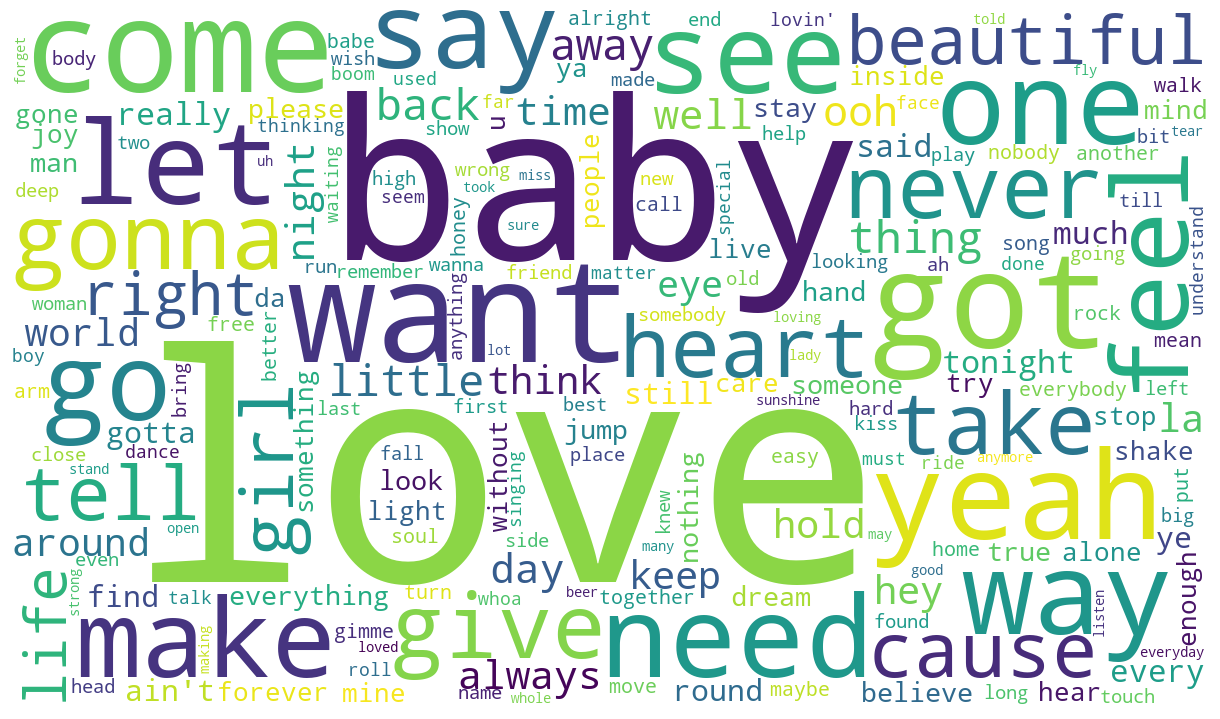

---------------------------------
--- Analysis of emotion anticipation ---
-- Outliers of emotion anticipation
- 99th percentile value: 0.5283369272237209


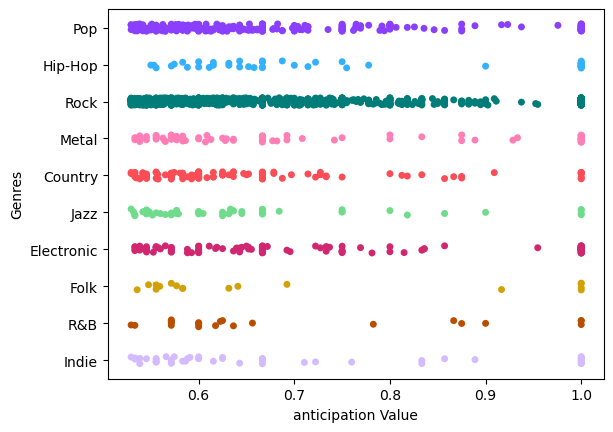

-- Number of outliers:
{'Pop': 289, 'Hip-Hop': 50, 'Rock': 1093, 'Metal': 77, 'Country': 114, 'Jazz': 51, 'Electronic': 132, 'Folk': 17, 'R&B': 23, 'Indie': 48}
{'Pop': 1.004902813032442, 'Hip-Hop': 0.24794208072994148, 'Rock': 1.2144714326985044, 'Metal': 0.3727369542066028, 'Country': 0.9736932012299283, 'Jazz': 1.0552451893234016, 'Electronic': 2.1404248419004377, 'Folk': 1.0698552548772813, 'R&B': 0.8415660446395902, 'Indie': 1.7284839755131436}
-- Artist list
eric-clapton        12
cheap-trick          9
eddy-arnold          9
bryan-adams          8
the-cure             7
                    ..
feint-boyinaband     1
electric-six         1
divine               1
aoa                  1
gemini               1
Name: artist, Length: 1201, dtype: int64
-- Wordcloud for anticipation


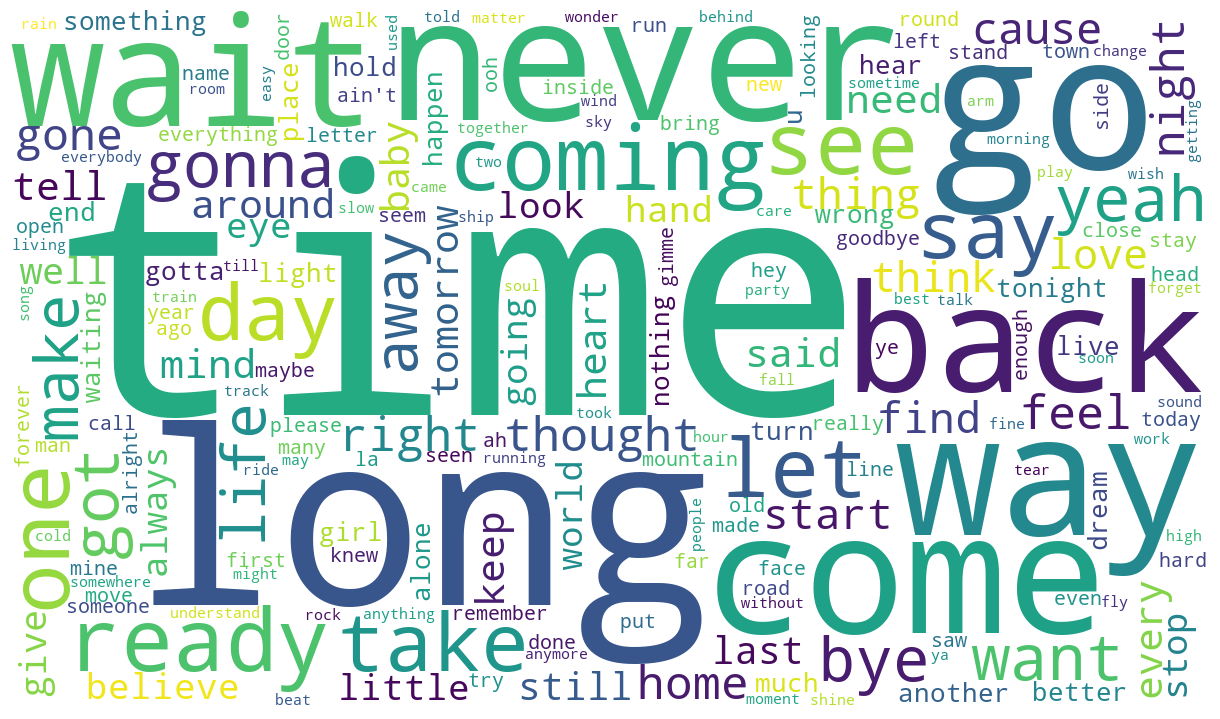

---------------------------------


In [ ]:
outlierAnalysis(df)

### Compute the emotions for genres

In [ ]:
df_emotions = emotionsPerGenre(df, list(df.genre.unique()))
df_emotions

genre      fear     anger     trust  surprise   sadness   disgust  \
0         Pop  0.116705  0.080202  0.152812  0.080295  0.130248  0.059841   
1     Hip-Hop  0.143987  0.142900  0.140988  0.075709  0.124253  0.104151   
2        Rock  0.130645  0.093847  0.151161  0.077848  0.139944  0.072124   
3       Metal  0.179155  0.127668  0.126071  0.062339  0.165057  0.095515   
4     Country  0.100231  0.071661  0.162568  0.082309  0.133518  0.058769   
5        Jazz  0.090753  0.064599  0.165511  0.082611  0.121639  0.053562   
6  Electronic  0.125669  0.087389  0.147431  0.075242  0.133828  0.060365   
7        Folk  0.120277  0.083304  0.163982  0.075577  0.131178  0.061287   
8         R&B  0.116057  0.082445  0.154984  0.073573  0.128037  0.063653   
9       Indie  0.121568  0.082055  0.157431  0.081734  0.144969  0.062635   

        joy  anticipation  
0  0.211848      0.163459  
1  0.132137      0.129725  
2  0.165079      0.163652  
3  0.101887      0.131028  
4  0.214136      0.174844  
5  0.244810      0.170515  
6  0.180726      0.159351  
7  0.182709      0.167211  
8  0.222171      0.155055  
9  0.172501      0.171705

In [ ]:
df_emotions.describe()

fear      anger      trust   surprise    sadness    disgust  \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    0.124505   0.091607   0.152294   0.076724   0.135267   0.069190   
std     0.024250   0.024621   0.011977   0.006022   0.012516   0.016925   
min     0.090753   0.064599   0.126071   0.062339   0.121639   0.053562   
25%     0.116219   0.080665   0.148364   0.075326   0.128590   0.059972   
50%     0.120923   0.082874   0.153898   0.076779   0.132348   0.061961   
75%     0.129401   0.092232   0.161284   0.081374   0.138415   0.070007   
max     0.179155   0.142900   0.165511   0.082611   0.165057   0.104151   

             joy  anticipation  
count  10.000000     10.000000  
mean    0.182801      0.158654  
std     0.043152      0.016014  
min     0.101887      0.129725  
25%     0.166934      0.156129  
50%     0.181717      0.163556  
75%     0.213564      0.169689  
max     0.244810      0.174844

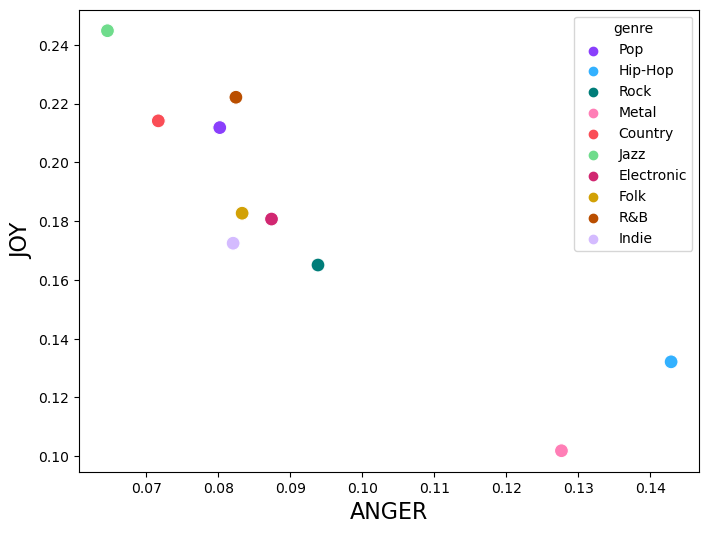

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='anger', y='joy', data=df_emotions, hue='genre', palette=c, s=100)
plt.xlabel('ANGER', size=16)
plt.ylabel('JOY', size=16)
plt.show()

## t-SNE - outliers

In [ ]:
idx_outlier = []
emotions_list = ['fear', 'anger', 'trust', 'surprise', 'sadness', 'disgust', 'joy', 'anticipation']

for e in emotions_list:
    idx_outlier.extend(outlierExtraction(df, e, 0.99))

In [ ]:
print (len(list(set(idx_outlier))), len(idx_outlier))

14289 15109


In [ ]:
out = list(set(idx_outlier))
out.sort()

In [ ]:
df_outliers = df.loc[out].copy(deep=True)

In [ ]:
df_X, df_y = generateDataframeValues(df_outliers)
df_X_scaled = StandardScaler().fit_transform(df_X)

In [ ]:
tsne = TSNE(n_components=2, perplexity=250, random_state=42)
X_tsne = tsne.fit_transform(df_X)

c:\Users\crocc\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\crocc\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


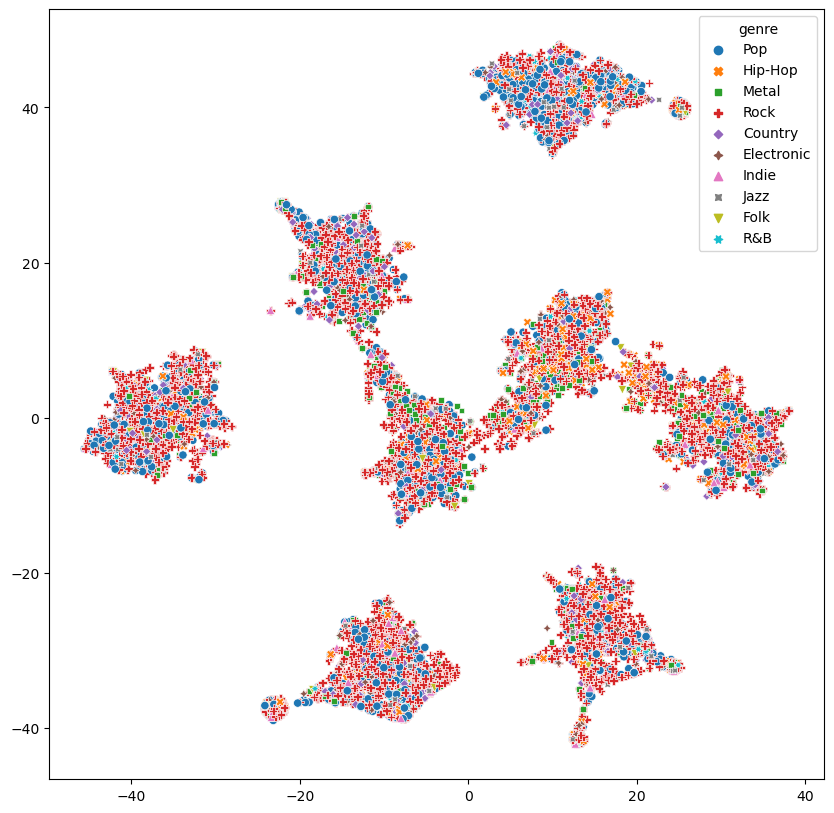

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df_y, style=df_y)
plt.show()

### t-SNE - all songs

In [ ]:
df_X, df_y = generateDataframeValues(df)

In [ ]:
df_X_scaled = StandardScaler().fit_transform(df_X)

In [ ]:
tsne = TSNE(n_components=2, perplexity=250, random_state=42) #~40 minuti
X_tsne = tsne.fit_transform(df_X)

c:\Users\crocc\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\crocc\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


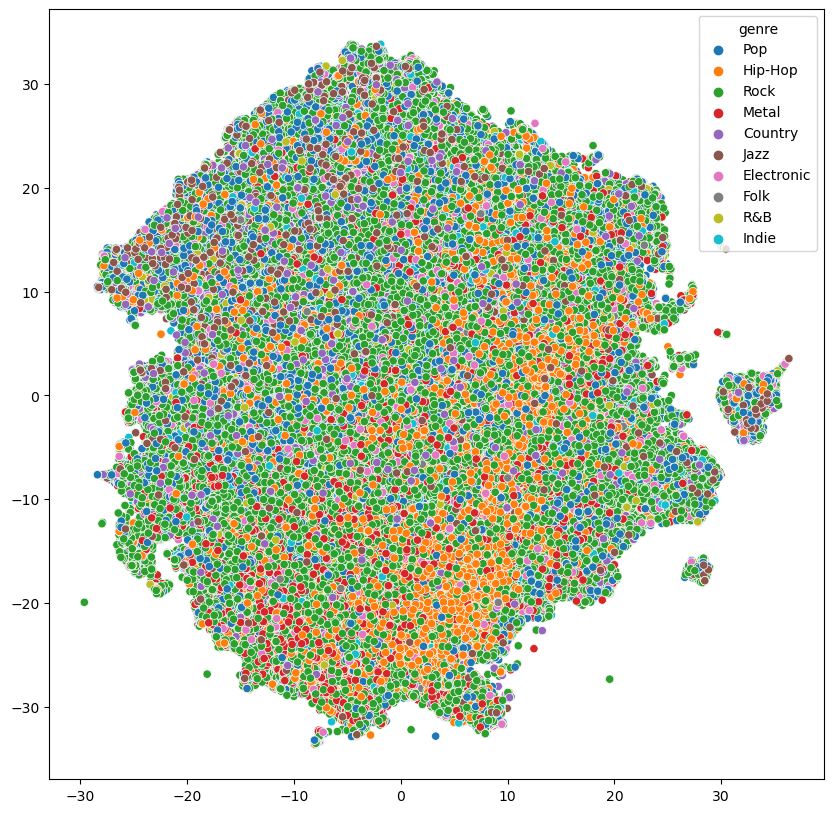

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df_y)
plt.show()

In [ ]:
tsne = TSNE(n_components=2, perplexity=400, random_state=42) #~50 minuti
X_tsne = tsne.fit_transform(df_X)

c:\Users\crocc\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\crocc\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


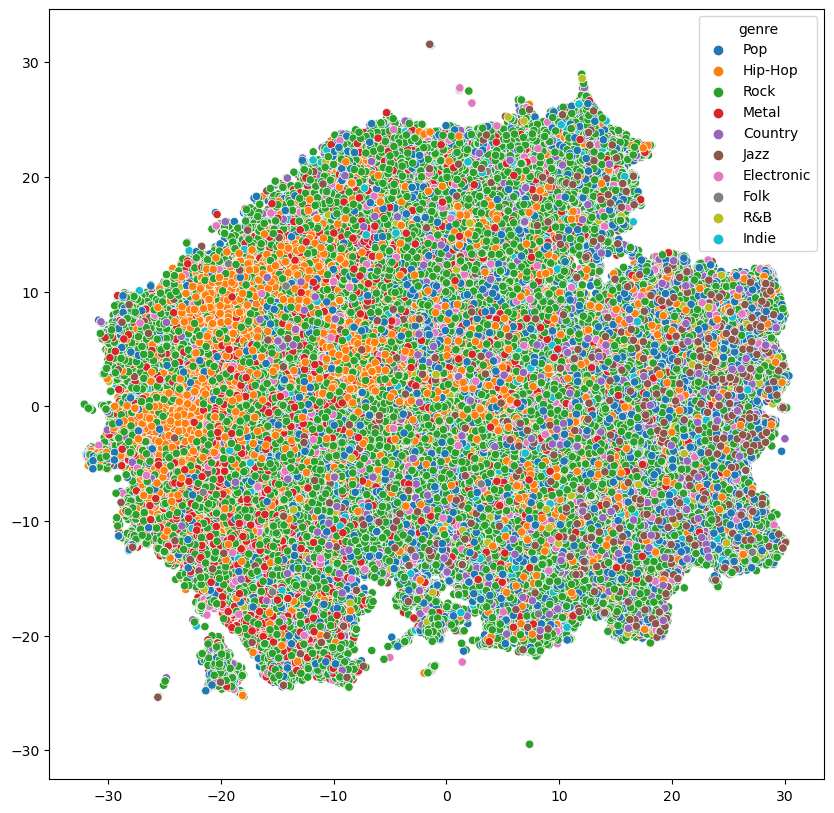

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df_y)
plt.show()

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42) #~50 minuti
X_tsne = tsne.fit_transform(df_X)

c:\Users\crocc\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\crocc\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


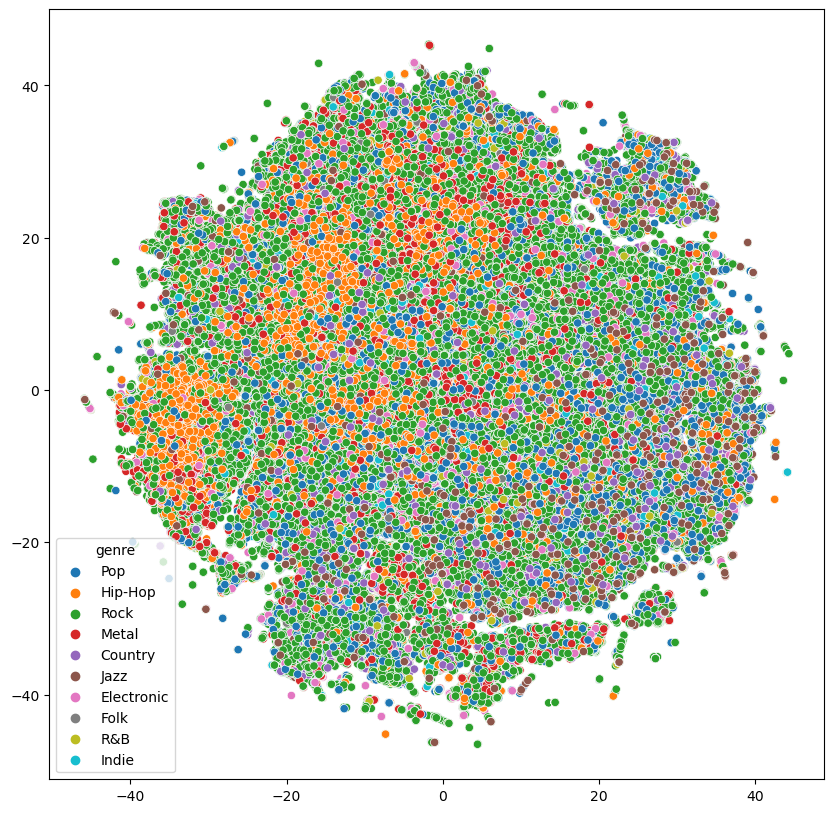

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df_y)
plt.show()

In [ ]:
### Visualizzare gli outliers

## UMAP

In [ ]:
#install datashader bokeh holoviews

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

import umap
import umap.plot

In [ ]:
df_X, df_y = generateDataframeValues(df)
df_X_scaled = StandardScaler().fit_transform(df_X)

In [ ]:
mapper = umap.UMAP(n_neighbors=15, random_state=42).fit(df_X_scaled)

<AxesSubplot:>

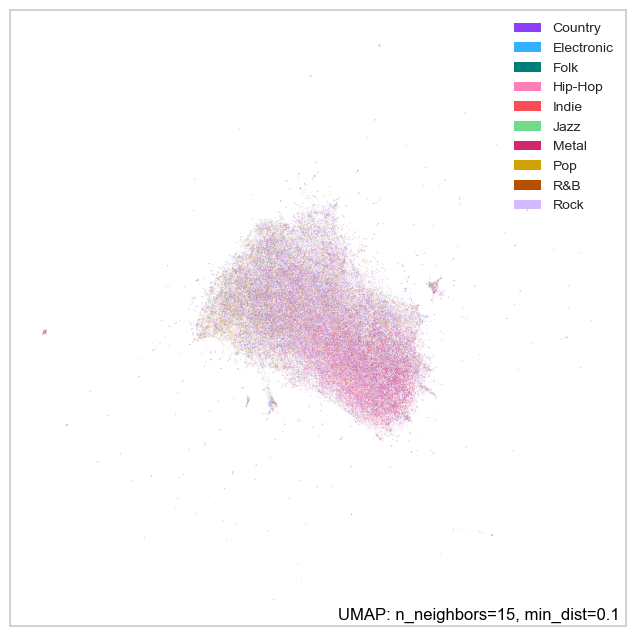

In [ ]:
# n_neighbors=15
umap.plot.points(mapper, labels=df_y, color_key_cmap=col)

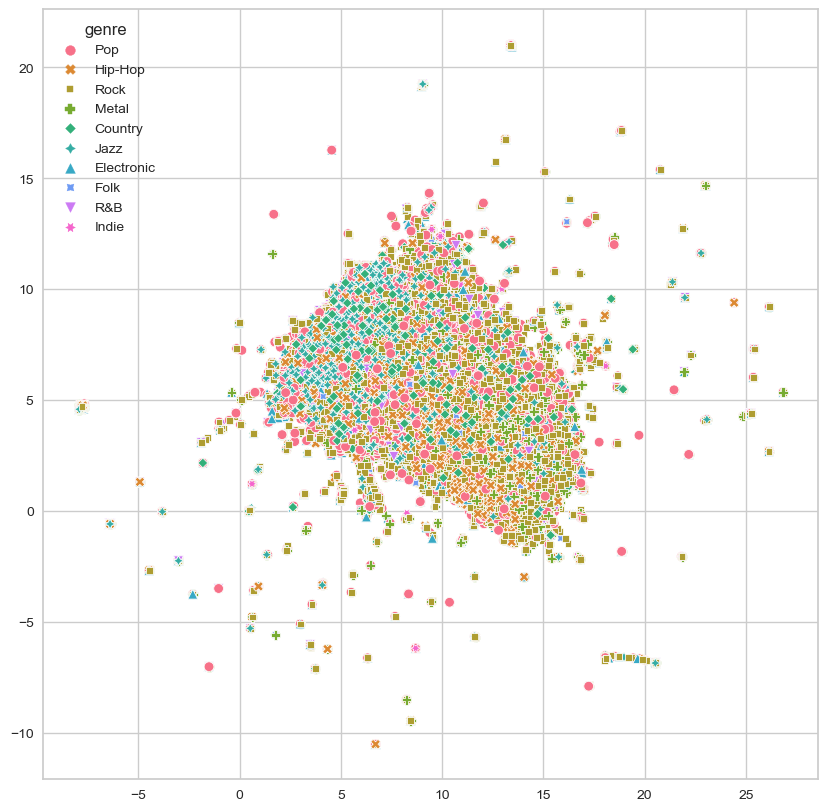

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=mapper.embedding_[:, 0], y=mapper.embedding_[:, 1], hue=df_y, style=df_y)
plt.show()

<AxesSubplot:>

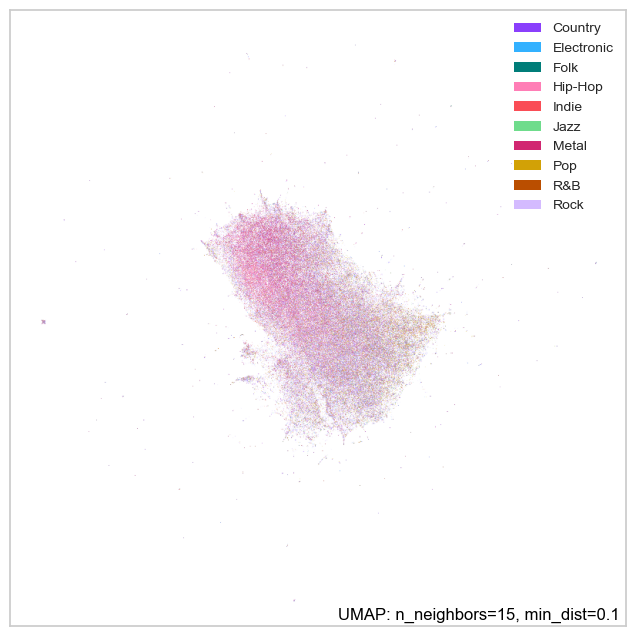

In [ ]:
# n_neighbors=15
umap.plot.points(mapper, labels=df_y, color_key_cmap=col)